In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:

def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [3]:
def chi2_without_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

def params_to_chi2(theta, model, dataset_CC=None,dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5)):

    #chi2_SN = 0
    #chi2_CC = 0
    
    [Mabs, L_bar, b, H_0, r, s] = theta
    physical_params = [L_bar, b, H_0, r, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    Hs_interp = interp1d(zs_model, Hs_model)

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_CC != None:
        z_data, H_data, dH = dataset_CC #Import the data
        H_teo = Hs_interp(z_data)
        chi2_CC = chi2_without_cov(H_teo, H_data, dH**2)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN + chi2_CC

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [4]:
#Fix params
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

z = np.linspace(0, 1000, int(10e3))

num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters

# GILA model analysis

In [ ]:
#GILA MODEL
#r_min = 3
#s_min = 1

#r = 3; s = 1 #chi2_min > chi2_threshold (does not work)
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 8; s = 1 #chi2_min > chi2_threshold (does not work)
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 2 #chi2_min > chi2_threshold (does not work)
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 4 #It works!
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 5 #It works!
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)
##H0_values = np.linspace(60,80,100)[::-1] 
##beta_values = np.linspace(0.1,12,100)
##Mabs_values = np.linspace(-21,-18.5,100)

r = 3; s = 6 #It works!
H0_values = np.linspace(60,80,20)[::-1] 
beta_values = np.linspace(0.1,12,20)
Mabs_values = np.linspace(-21,-18.5,20)

print(H0_values, beta_values, Mabs_values)

matrix_gila_chi2 = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
matrix_gila_aou = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
#mask_1_sigma = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
#mask_aou = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))

for (i, (H0_val, beta_val, Mabs_val)) in enumerate(product(H0_values, beta_values, Mabs_values)):
    physical_params = [L_bar, beta_val, H0_val, r, s]
    try :        
        z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                        initial_z=z[0], final_z=z[-1])
    except Exception as e:
        # If integration fails
        matrix_gila_chi2.flat[i] = np.nan
        continue

    theta = [Mabs_val, L_bar, beta_val, H0_val, r, s]
    chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, dataset_CC=ds_CC, model='GILA') #/ dof
    
    matrix_gila_chi2.flat[i] = chi2 #/ dof
    
    aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
    matrix_gila_aou.flat[i] = aou_gila

    #if chi2 <= dof + np.sqrt(2*dof): #change condition with respect to the older notebook
    #    mask_1_sigma.flat[i] = 1

    #if aou_gila >= aou_threshold: #change condition with respect to the older notebook
    #    mask_aou.flat[i] = 1

[80.         78.94736842 77.89473684 76.84210526 75.78947368 74.73684211
 73.68421053 72.63157895 71.57894737 70.52631579 69.47368421 68.42105263
 67.36842105 66.31578947 65.26315789 64.21052632 63.15789474 62.10526316
 61.05263158 60.        ] [ 0.1         0.72631579  1.35263158  1.97894737  2.60526316  3.23157895
  3.85789474  4.48421053  5.11052632  5.73684211  6.36315789  6.98947368
  7.61578947  8.24210526  8.86842105  9.49473684 10.12105263 10.74736842
 11.37368421 12.        ] [-21.         -20.86842105 -20.73684211 -20.60526316 -20.47368421
 -20.34210526 -20.21052632 -20.07894737 -19.94736842 -19.81578947
 -19.68421053 -19.55263158 -19.42105263 -19.28947368 -19.15789474
 -19.02631579 -18.89473684 -18.76315789 -18.63157895 -18.5       ]


In [6]:
#np.save(os.path.join(path_data, 'matrix_gila_chi2.npy'), matrix_gila_chi2)
#np.save(os.path.join(path_data, 'matrix_gila_aou.npy'), matrix_gila_aou)

#np.save(os.path.join(path_data, 'matrix_chi2_{0}_r={1}_s={2}_100.npy'.format('GILA',r, s)), matrix_gila_chi2)
#np.save(os.path.join(path_data, 'matrix_aou_{0}_r={1}_s={2}_100.npy'.format('GILA',r, s)), matrix_gila_aou)

np.save(os.path.join(path_data, 'matrix_chi2_{0}_r={1}_s={2}.npy'.format('GILA',r, s)), matrix_gila_chi2)
np.save(os.path.join(path_data, 'matrix_aou_{0}_r={1}_s={2}.npy'.format('GILA',r, s)), matrix_gila_aou)

In [7]:
#Fix params
#beta = 1e-5
L_bar = 0.90
num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters

confidence_level = 0.683 #1 sigma contour
#confidence_level = 0.954 #2 sigma contour
#confidence_level = 0.997 #3 sigma contour

In [8]:
from scipy.stats import chi2

def chi2_threshold(N, p, confidence):
    """
    Compute the chi-square threshold for model rejection based on a given confidence level.
    
    Parameters:
    N (int): Number of data points
    p (int): Number of parameters
    confidence (float): Confidence level (e.g., 0.95 for 95%)
    
    Returns:
    float: Reduced chi-square threshold
    """
    nu = N - p  # Degrees of freedom
    chi2_crit = chi2.ppf(confidence, df=nu)  # Critical chi-square value
    return chi2_crit / nu  # Convert to reduced chi-square

# Example usage
N = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])
p = 3
confidence_level = 0.683  # 68.3% confidence threshold

chi2_th = chi2_threshold(N, p, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {chi2_th:.5f}")
print(1+np.sqrt(2/(N-p)))


Reduced chi-square threshold for 68.30000000000001% confidence: 1.01610
1.0344622758397788


In [9]:
#aou_threshold = 13.2
aou_threshold = 12.7
chi2_th = chi2_threshold(N, p, confidence_level)
print('Aou threhold: {}'.format(aou_threshold))
print('chi2 threhold: {}'.format(chi2_th))

masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)

print('Has integration issues?: {}'.format(np.all(np.isnan(matrix_gila_chi2)))) #should be False
print('Has issues when Aou cut-off is applied?: {}'.format(np.all(np.isnan(masked_data_with_aou))))#should be False
print('chi2_min<=chi2_threshold?: {}'.format(np.nanmin(masked_data_with_aou)/dof<=chi2_th))#should be True


Aou threhold: 12.7
chi2 threhold: 1.0160978536321694
Has integration issues?: False
Has issues when Aou cut-off is applied?: False
chi2_min<=chi2_threshold?: True


In [10]:
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(masked_data_with_aou)/dof))

#Double check
where_global_min = np.where(masked_data_with_aou==np.nanmin(masked_data_with_aou))
masked_data_with_aou[where_global_min]/dof

Minimum of the reduced $\chi^2$:0.9143123311708561


array([0.91431233])

In [11]:
masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)
masked_data_with_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, matrix_gila_chi2, np.nan)
masked_data_with_aou_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, masked_data_with_aou, np.nan)

print(masked_data_with_aou)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

[[[            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  ...
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]]

 [[            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  ...
  [            nan     

In [12]:
print(r'The global minima corresponds to M abs={0}'.format(Mabs_values[where_global_min[2][0]]))
matrix_gila_chi2_2d = matrix_gila_chi2[:,:,where_global_min[2][0]]/dof
masked_data_with_aou_2d = masked_data_with_aou[:,:,where_global_min[2][0]]/dof
masked_data_with_1_sigma_2d = masked_data_with_1_sigma[:,:,where_global_min[2][0]]/dof
masked_data_with_aou_1_sigma_2d = masked_data_with_aou_1_sigma[:,:,where_global_min[2][0]]/dof

The global minima corresponds to M abs=-19.289473684210527


/home/matias/miniconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


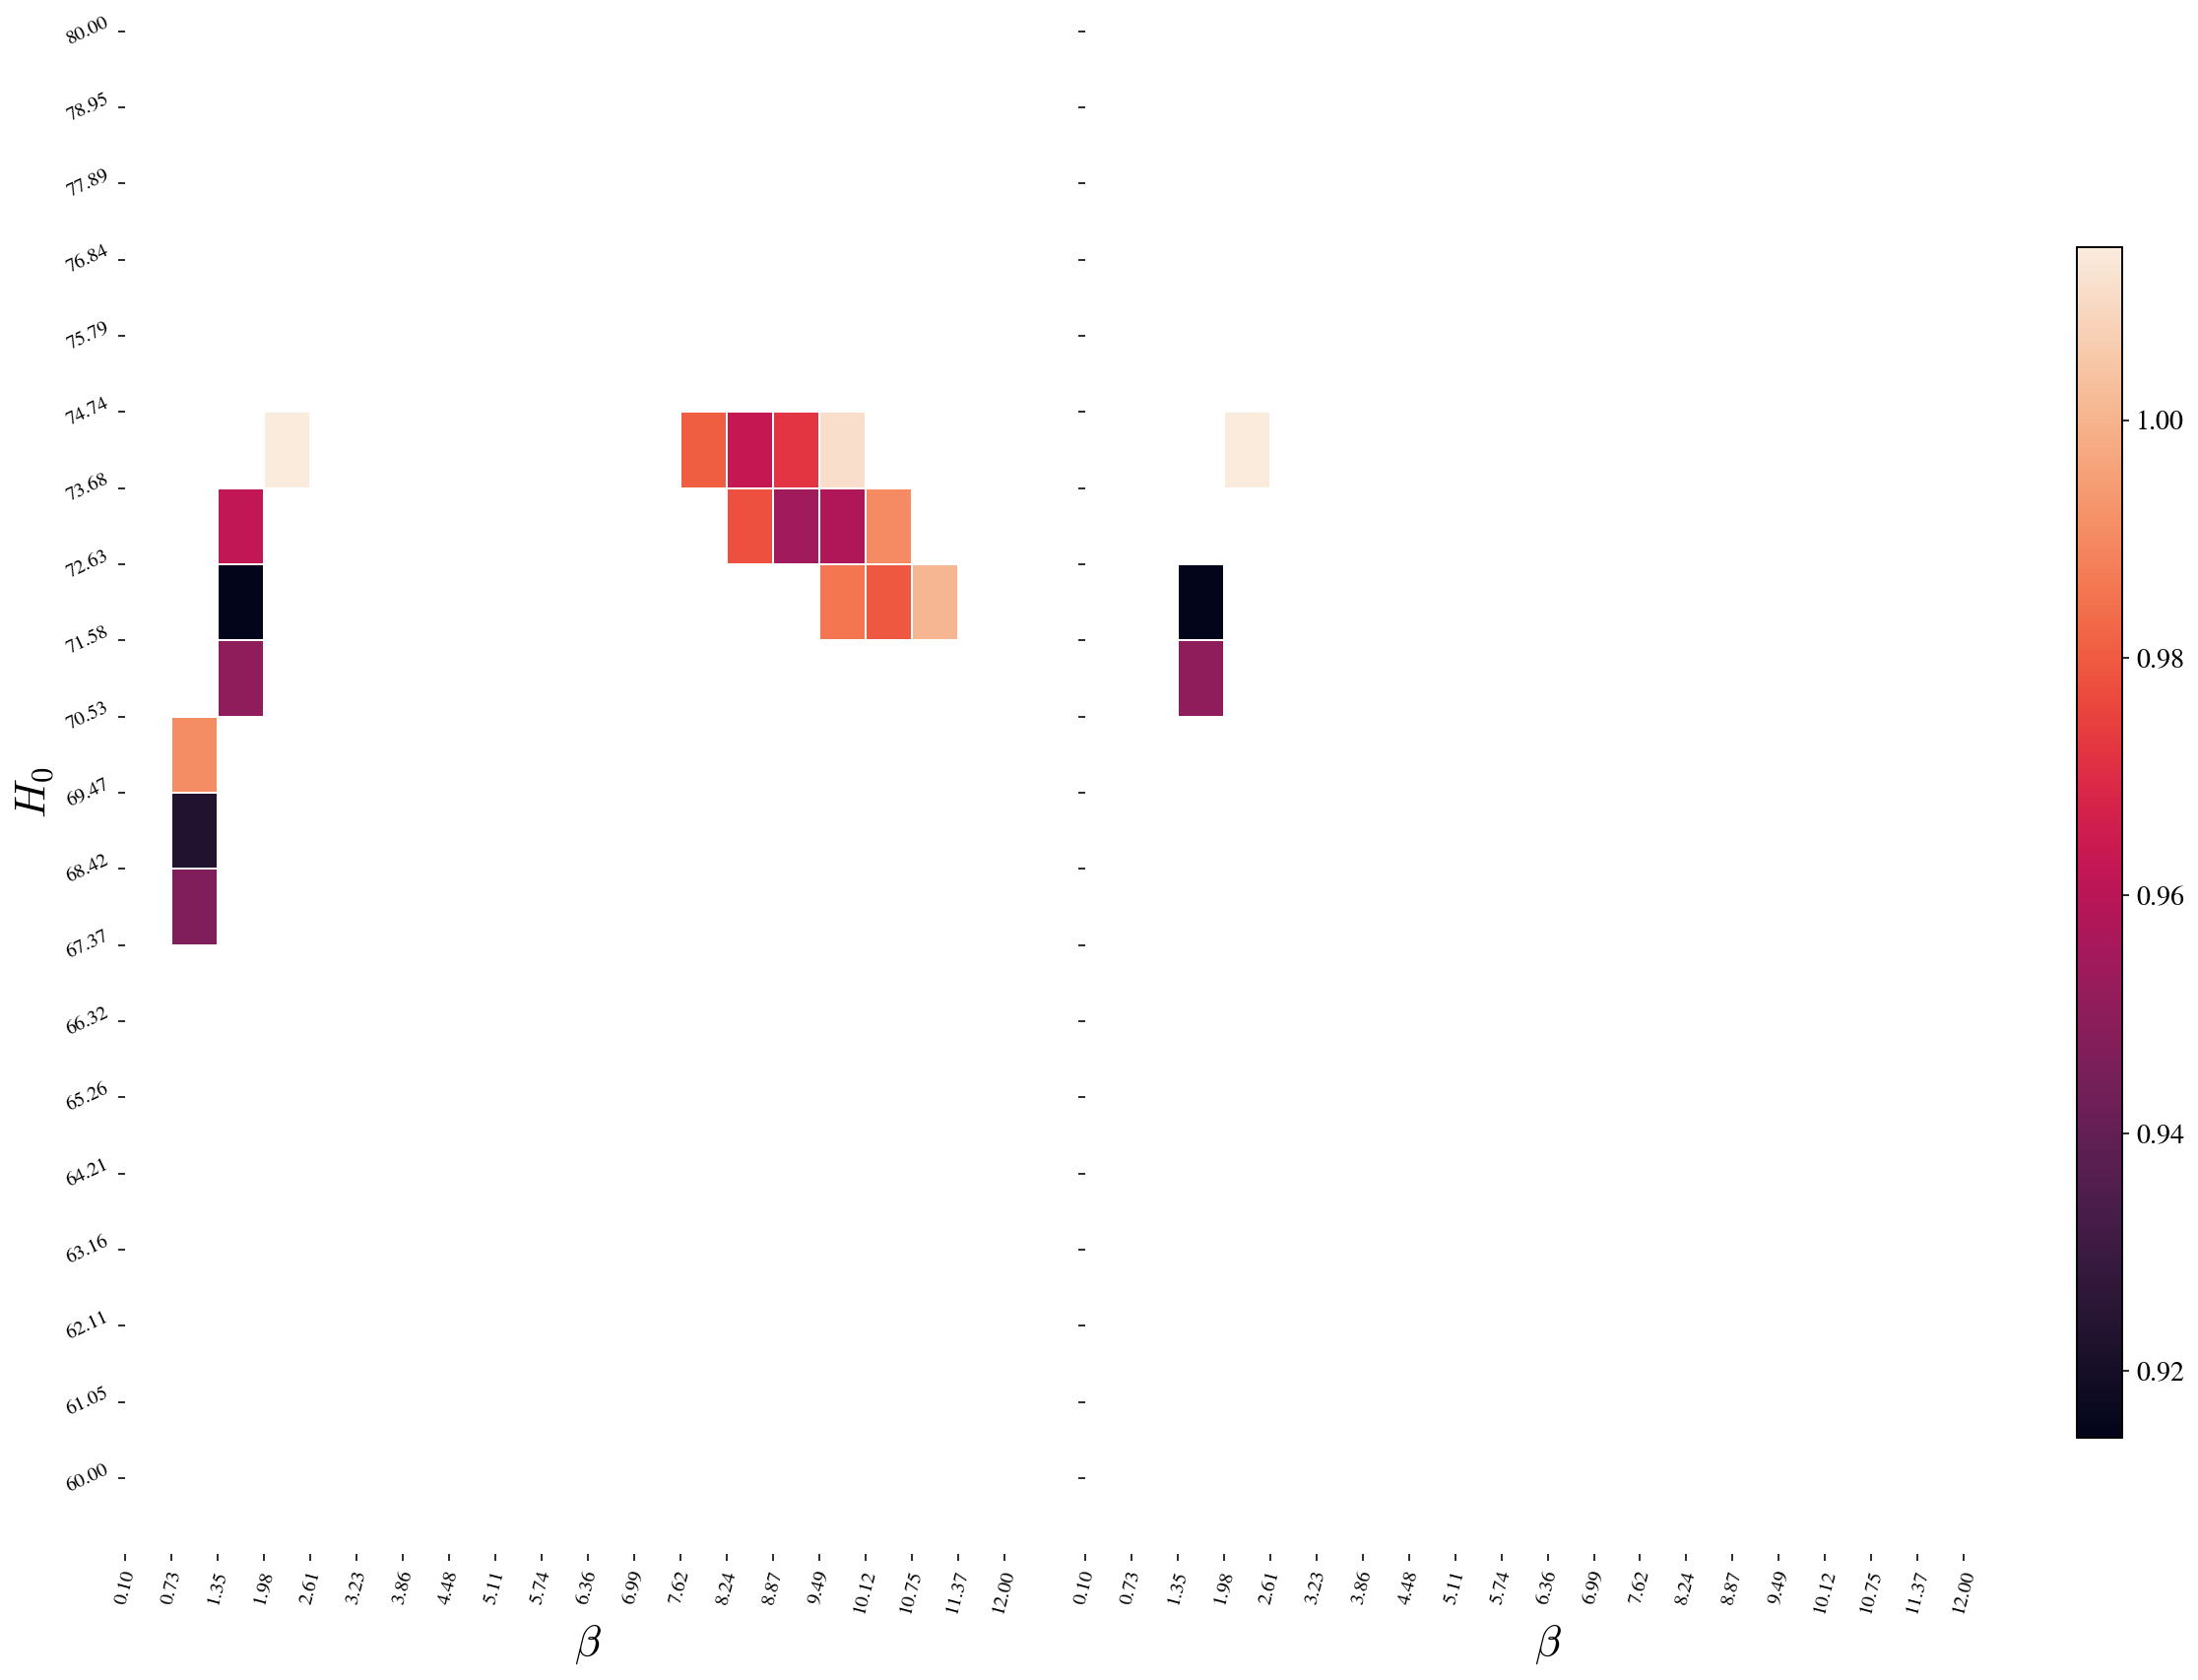

In [13]:
# Plot GILA model
fig, axes = plt.subplots(1,2,figsize=(16, 12))
# Define common color scale
vmin = min(np.nanmin(masked_data_with_1_sigma_2d), np.nanmin(masked_data_with_aou_1_sigma_2d))
vmax = max(np.nanmax(masked_data_with_1_sigma_2d), np.nanmax(masked_data_with_aou_1_sigma_2d))

# Plot heatmaps without colorbars
sns.heatmap(masked_data_with_1_sigma_2d, ax=axes[0], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(masked_data_with_aou_1_sigma_2d, ax=axes[1], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)

# General configurations for all axes
for ax in axes.flat:
    ax.set_xlabel(r'$\beta$', fontsize=22)
    ax.set_ylabel(r'$H_0$', fontsize=22)
    ax.set_xticks(np.arange(len(beta_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values],rotation = 75)
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values],rotation = 25)
    ax.label_outer()

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position as needed
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

# Change colorbar tick label size
cbar.ax.tick_params(labelsize=14)  # Set fontsize

fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_L={2}.png'.format(r,s,0.9)))
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_L={2}.pdf'.format(r,s,0.9)))
plt.show()

